In [1]:
import pandas as pd
import numpy as np
import ruptures as rp
from prediction_pipeline.preprocessing import *
from sklearn.linear_model import LinearRegression
from glob import glob
from multiprocessing import Pool
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import PCA, FactorAnalysis

/home/hv270/platelets/lib/python3.7/site-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


In [2]:
# Si la PCA par individu ne marche pas, possible d'essayer la PCA par sous-cohorte d'interval

In [3]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"

In [4]:
PLT = pd.read_hdf("%s/processed/PLT.hdf" % data_dir,key="PLT")

In [5]:
X = PLT

In [6]:
sys_cohort = ~PLT.ID.str.contains("INT_116")

In [7]:
plt_sys = PLT.loc[sys_cohort].sample(3000)
plt_int = PLT.loc[~sys_cohort].sample(3000)

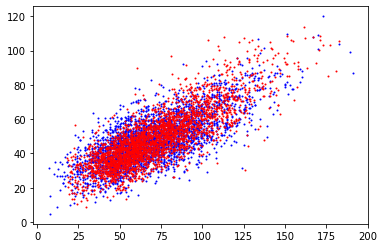

In [8]:
plt.scatter(plt_sys["FSC"],plt_sys["SSC"],c="blue",s=1)
plt.scatter(plt_int["FSC"],plt_int["SSC"],c="red",s=1)

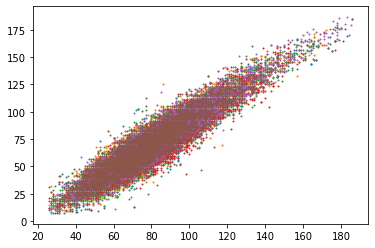

In [10]:
i = 0
for ID, sys in PLT.loc[sys_cohort].groupby("ID"):
    #plt.figure()
    plt.scatter(sys.SFL, sys.FSC, s= 1)
    i += 1
    if i > 5:
        break

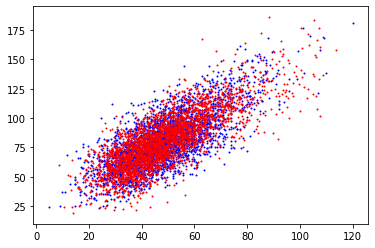

In [11]:
plt.scatter(plt_sys["SSC"],plt_sys["SFL"],c="blue",s=1)
plt.scatter(plt_int["SSC"],plt_int["SFL"],c="red",s=1)

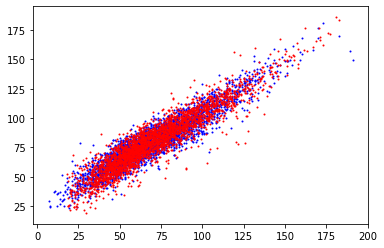

In [12]:
plt.scatter(plt_sys["FSC"],plt_sys["SFL"],c="blue",s=1)
plt.scatter(plt_int["FSC"],plt_int["SFL"],c="red",s=1)

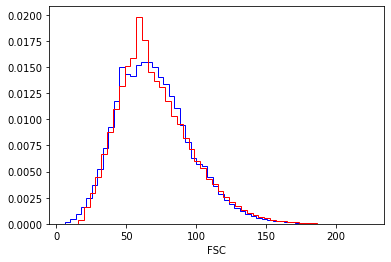

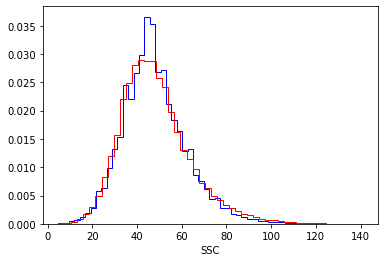

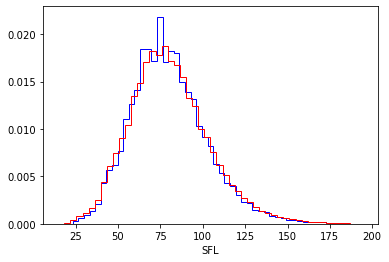

In [13]:
for c in FACS_COLS:
    plt.figure()
    plt.hist(PLT.loc[sys_cohort,c],histtype="step",density=True,bins=50,color="blue")
    plt.hist(PLT.loc[~sys_cohort,c],histtype="step",density=True,bins=50,color="red")
    plt.xlabel(c)

In [14]:
#X = X.loc[sys_cohort]

# Plan
- Apply PCA on individuals
- compute features for the first time
- detect cohorts
- apply PCA per cohort
- compute final features

# Apply PCA and build features

In [15]:
def apply_individual_pca(args):
    ID, df = args
    pca = PCA(n_components=2).fit(df[FACS_COLS])
    pca.components_[0,:] /= np.sign(pca.components_[0,1])
    pca.components_[1,:] /= np.sign(pca.components_[1,1])
    df[["X_0","X_1"]] = pca.transform(df[FACS_COLS])
    df["ID"] = ID
    w = np.reshape(pca.components_,(-1,))
    return df, pd.Series(w), ID

In [16]:
g = X.groupby("ID")
X_IDs = X.ID.unique().tolist()

In [ ]:
p = Pool(15)
Xs = []
pc_comps = {}
for result in tqdm(p.imap_unordered(apply_individual_pca, g), total = len(X_IDs)):
    X_, w, ID = result
    Xs.append(X_)
    pc_comps[ID] = w
p.close()
p.join()

 16%|█▌        | 5303/33367 [02:06<11:24, 41.02it/s]

In [116]:
X = pd.concat(Xs,axis=0)

In [117]:
pca_coefs = pd.DataFrame.from_dict(pc_comps,orient="index").add_prefix("PC_")

In [118]:
sys_cohort = ~X.ID.str.contains("INT_116")

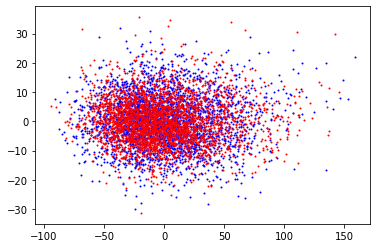

In [119]:
X_sys = X.loc[sys_cohort,["X_0","X_1"]].sample(3000)
X_int = X.loc[~sys_cohort,["X_0","X_1"]].sample(3000)
plt.scatter(X_sys["X_0"],X_sys["X_1"],c="blue",s=1)
plt.scatter(X_int["X_0"],X_int["X_1"],c="red",s=1)

In [120]:
def std_2nd_dim_high(df):
    Q_high = np.quantile(df.X_0,0.6)
    return df.loc[df.X_0 > Q_high,"X_1"].std()

def std_2nd_dim_low(df):
    Q_low = np.quantile(df.X_0,0.4)
    return df.loc[df.X_0 < Q_low,"X_1"].std()

In [121]:
g = X.groupby("ID")[["X_0","X_1"]]
mean = g.mean()
median = g.median()
upper = g.quantile(0.9)
lower = g.quantile(0.1)
#upper_ext = g.quantile(0.975)
#lower_ext = g.quantile(0.025)
std = g.std()
iqr = g.quantile(0.75) - g.quantile(0.25)
#skew = g.skew()


ratio_upper = np.log10((upper["X_1"] - median["X_1"])/ (upper["X_0"] - median["X_1"]))
ratio_lower = np.log10((median["X_1"] - lower["X_1"]) / (median["X_0"] - lower["X_0"]))
ratio_std = np.log10(std["X_1"] / std["X_0"])

In [122]:
std_2_high = g.apply(std_2nd_dim_high)
std_2_low = g.apply(std_2nd_dim_low)

In [123]:
features = pd.concat([#mean.rename(columns={"X_0":"mean_0","X_1":"mean_1"}),
           median.rename(columns={"X_0":"median_0","X_1":"median_1"}),
           upper.rename(columns={"X_0":"upper_0","X_1":"upper_1"}),
           lower.rename(columns={"X_0":"lower_0","X_1":"lower_1"}),
           #upper_ext.rename(columns={"X_0":"upper_ext_0","X_1":"upper_ext_1"}),
           #lower_ext.rename(columns={"X_0":"lower_ext_0","X_1":"lower_ext_1"}),
           std.rename(columns={"X_0":"std_0","X_1":"std_1"}),
           iqr.rename(columns={"X_0":"iqr_0","X_1":"iqr_1"}),
           #iqr_up_1.rename(columns={"X_1":"iqr_up_1"}),
           #iqr_low_1.rename(columns={"X_1":"iqr_low_1"}),
           #iqr_up_0.rename(columns={"X_0":"iqr_up_0"}),
           #iqr_low_0.rename(columns={"X_0":"iqr_low_0"}),
           #skew.rename(columns={"X_0":"skew_0","X_1":"skew_1"}),
           pd.DataFrame(ratio_upper).rename(columns={0:"ratio_upper"}),
           pd.DataFrame(ratio_lower).rename(columns={0:"ratio_lower"}),
           pd.DataFrame(ratio_std).rename(columns={0:"ratio_std"}),
           pd.DataFrame(std_2_high).rename(columns={0:"std_2_high"}),
           pd.DataFrame(std_2_low).rename(columns={0:"std_2_low"})],axis=1)
features = features.dropna(how="any",axis=0)

In [124]:
features = pd.merge(features, pca_coefs,left_index=True,right_index=True)

In [125]:
features

,median_0,median_1,upper_0,upper_1,lower_0,lower_1,std_0,std_1,iqr_0,iqr_1,...,ratio_lower,ratio_std,std_2_high,std_2_low,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5
C0WX14,-4.181785,-0.103070,41.438467,10.609063,-37.487007,-10.764779,32.798989,8.346957,40.454868,11.119555,...,-0.494685,-0.594332,8.874951,7.840189,0.720548,0.307990,0.621251,-0.341616,0.937342,-0.068477
C0WX4Z,-3.998882,-0.039965,43.770027,11.106810,-38.494406,-11.197107,33.906347,8.900580,42.696075,11.353965,...,-0.490210,-0.580863,9.656150,8.255723,0.722730,0.343717,0.599600,-0.286391,0.938515,-0.192796
C0WX6V,-3.383979,-0.222166,45.864050,11.242917,-43.113459,-11.132685,36.381407,8.918077,48.330431,11.493265,...,-0.561267,-0.610608,9.712586,8.327184,0.721614,0.334550,0.606093,-0.297553,0.940374,-0.164800
C0WX7T,-4.076989,0.058005,45.987701,11.104832,-40.152640,-11.469365,34.534457,8.892046,44.479822,12.041627,...,-0.495484,-0.589251,9.619497,7.994955,0.723996,0.332617,0.604314,-0.412580,0.910894,-0.007071
C0WX8R,-5.084672,-0.072010,46.665774,10.127888,-42.922255,-10.407640,37.507398,8.307566,47.903439,11.082363,...,-0.563586,-0.654643,8.893468,7.885796,0.725546,0.317799,0.610399,-0.289902,0.945587,-0.147723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INT_116_99600,-2.887758,-0.434774,44.026342,10.941339,-40.687063,-10.525222,32.807645,8.839281,43.405993,10.925578,...,-0.573573,-0.569558,9.772602,7.780194,0.705734,0.351497,0.615134,-0.237419,0.935379,-0.262103
INT_116_99700,-3.162634,-0.345763,42.891793,7.928006,-40.356999,-7.884160,33.588724,6.567135,45.309033,8.223632,...,-0.693198,-0.708818,6.928126,6.167853,0.708215,0.266093,0.653931,-0.087135,0.952115,-0.293059
INT_116_99800,-4.238040,-0.431910,43.700374,10.881930,-39.346063,-10.369772,33.696259,8.471844,42.849324,10.851867,...,-0.548113,-0.599604,9.275334,7.585146,0.708647,0.357060,0.608545,-0.266592,0.934061,-0.237611
INT_116_99900,-6.488622,-0.389345,54.521133,10.739489,-45.687176,-10.973686,40.053059,8.773857,49.885518,11.430998,...,-0.568606,-0.659445,9.542934,7.807618,0.700948,0.362676,0.614115,-0.266221,0.931869,-0.246467


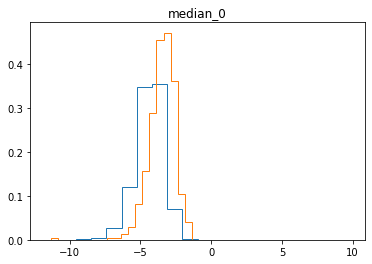

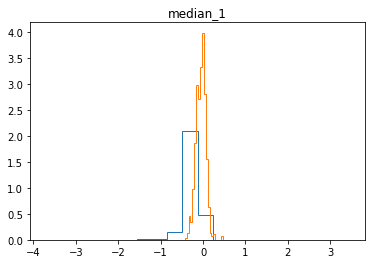

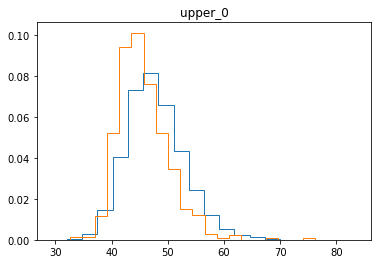

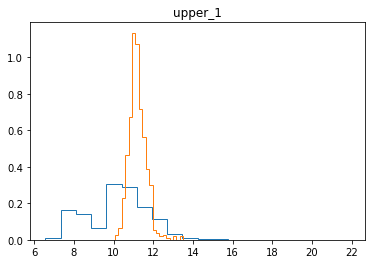

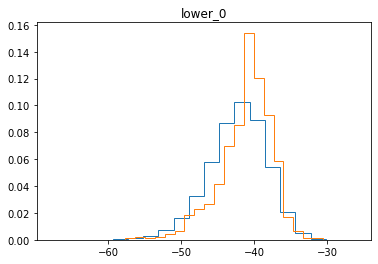

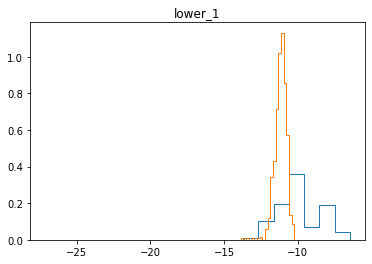

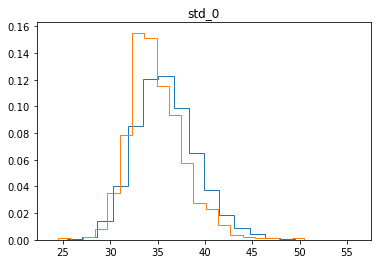

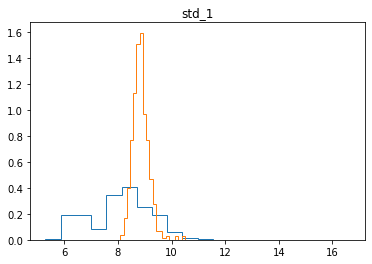

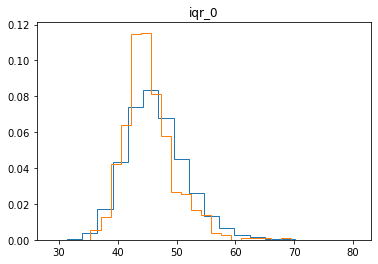

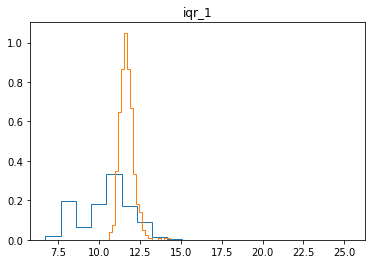

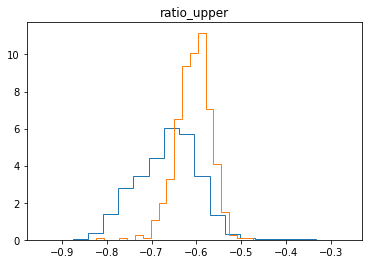

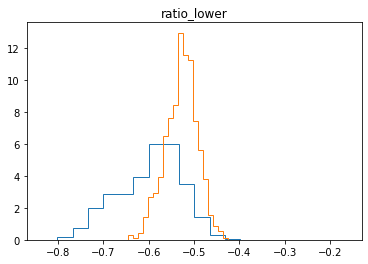

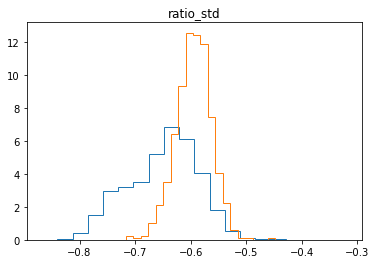

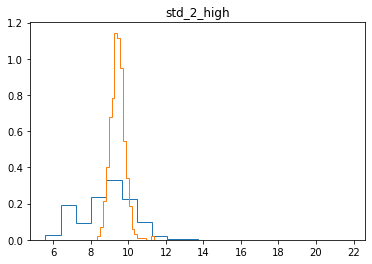

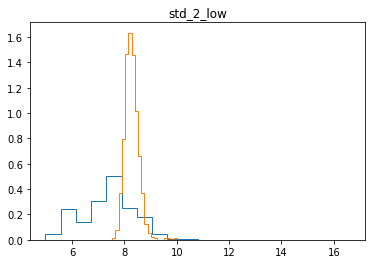

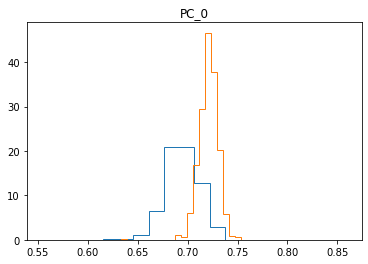

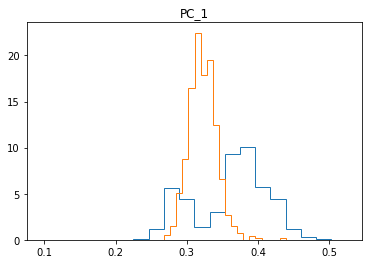

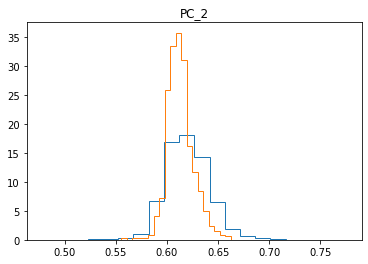

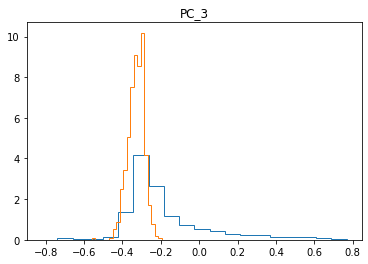

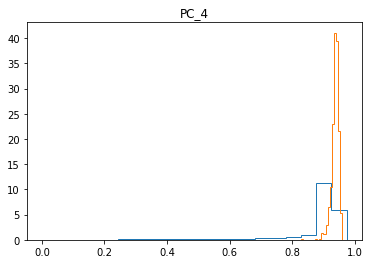

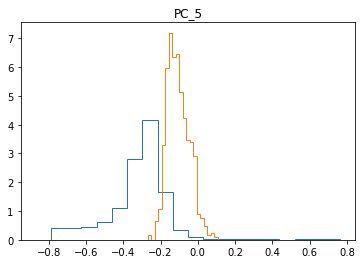

In [126]:
for c in features.columns:
    plt.figure()
    plt.hist(features.loc[features.index.str.contains("INT_116"),c],density=True,bins=20,histtype="step")
    plt.hist(features.loc[~features.index.str.contains("INT_116"),c],density=True,bins=20,histtype="step")
    plt.title(c)

# Time-cohort-machine adjust

## Sysmex cohort (PFC cohort)

In [127]:
sys_values = features.loc[~features.index.str.contains("INT_116")]

In [128]:
sys_phen = load_sys_phenotypes(data_dir)
sys_phen["time_col"] = pd.to_datetime(sys_phen["Date"],format="%d/%m/%Y")
sys_phen.sort_values("time_col",inplace=True)

602 candidates summary files
Initially 1068 rows, 643 unique IDs
Finally 642 rows, 642 unique IDs


In [129]:
sys_info = pd.merge(sys_values,sys_phen.set_index("ID")[["time_col"]],left_index=True,right_index=True).sort_values("time_col")

In [130]:
sys_info.head()

,median_0,median_1,upper_0,upper_1,lower_0,lower_1,std_0,std_1,iqr_0,iqr_1,...,ratio_std,std_2_high,std_2_low,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,time_col
C0WX14,-4.181785,-0.103070,41.438467,10.609063,-37.487007,-10.764779,32.798989,8.346957,40.454868,11.119555,...,-0.594332,8.874951,7.840189,0.720548,0.307990,0.621251,-0.341616,0.937342,-0.068477,2016-01-12
C0WX4Z,-3.998882,-0.039965,43.770027,11.106810,-38.494406,-11.197107,33.906347,8.900580,42.696075,11.353965,...,-0.580863,9.656150,8.255723,0.722730,0.343717,0.599600,-0.286391,0.938515,-0.192796,2016-01-12
C0WX6V,-3.383979,-0.222166,45.864050,11.242917,-43.113459,-11.132685,36.381407,8.918077,48.330431,11.493265,...,-0.610608,9.712586,8.327184,0.721614,0.334550,0.606093,-0.297553,0.940374,-0.164800,2016-01-12
C0WX7T,-4.076989,0.058005,45.987701,11.104832,-40.152640,-11.469365,34.534457,8.892046,44.479822,12.041627,...,-0.589251,9.619497,7.994955,0.723996,0.332617,0.604314,-0.412580,0.910894,-0.007071,2016-01-12
C0WX8R,-5.084672,-0.072010,46.665774,10.127888,-42.922255,-10.407640,37.507398,8.307566,47.903439,11.082363,...,-0.654643,8.893468,7.885796,0.725546,0.317799,0.610399,-0.289902,0.945587,-0.147723,2016-01-12


In [131]:
X = sys_info[features.columns].values
X -= np.mean(X,axis=0)
X /= np.std(X,axis=0)

In [132]:
algo_c = rp.KernelCPD(kernel="rbf", min_size=80).fit(
    X
)

6 BKPS


<Figure size 720x288 with 0 Axes>

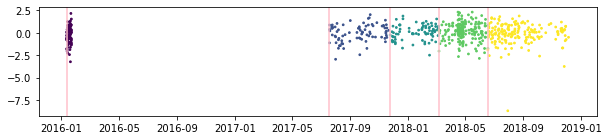

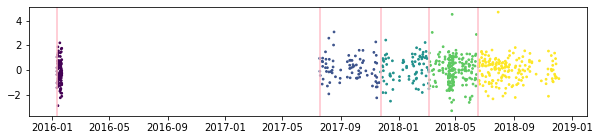

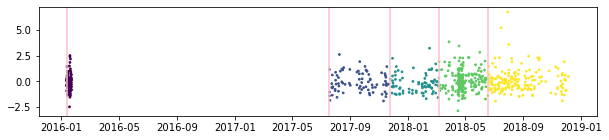

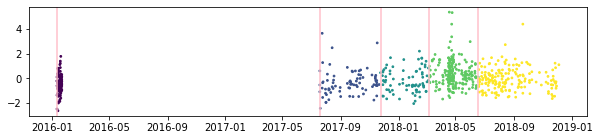

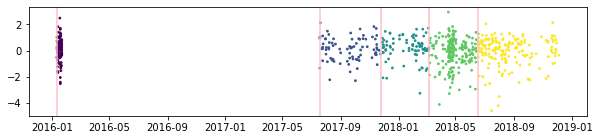

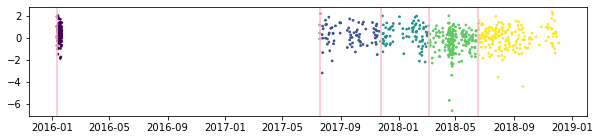

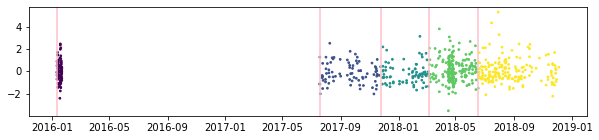

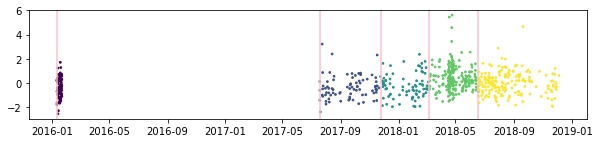

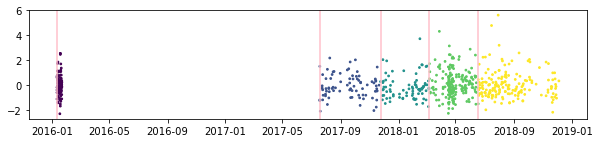

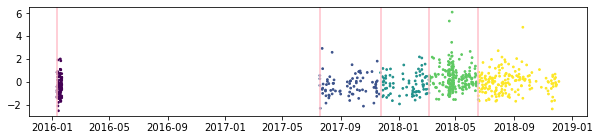

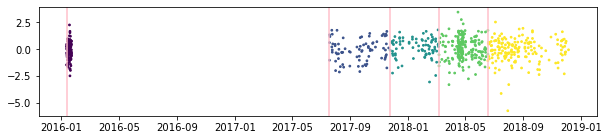

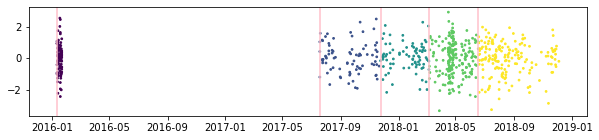

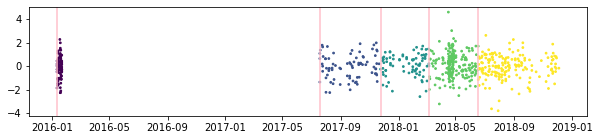

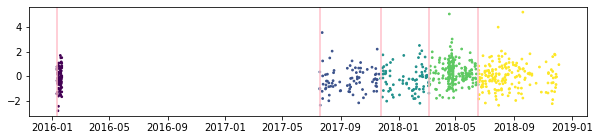

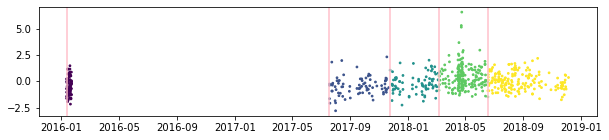

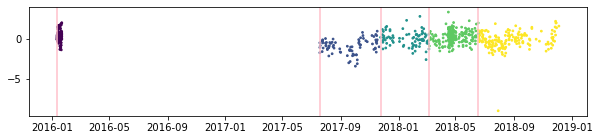

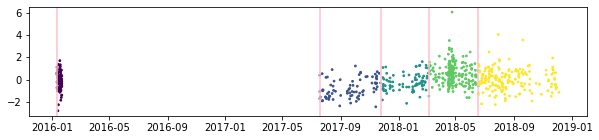

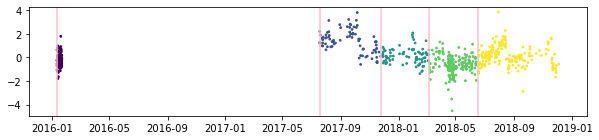

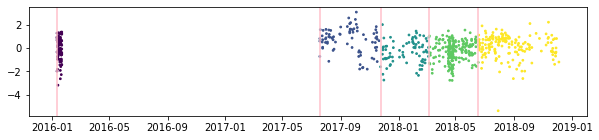

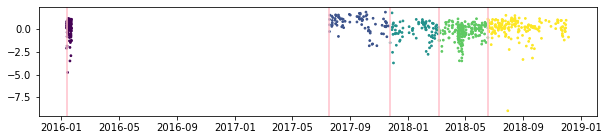

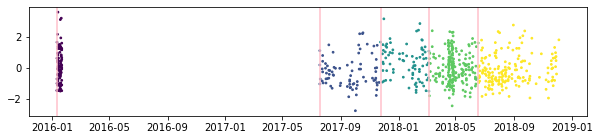

In [133]:
bkps = algo_c.predict(pen=2)
bkps = [0] + bkps
print("%d BKPS" % len(bkps))

sys_info["cohort"] = 0
sys_info["rank"] = np.arange(sys_info.shape[0])
for b in bkps[1:]:
    sys_info.loc[sys_info["rank"] >= b,"cohort"] += 1
    
plt.figure(figsize=(10,4))
for i in range(X.shape[1]):
    plt.figure(figsize=(10,2))
    plt.scatter(sys_info["time_col"],X[:,i],s=3,c=sys_info.cohort)
    for b in bkps[:-1]:
        plt.axvline(sys_info["time_col"].iloc[b],c="pink")

## Interval cohort

In [134]:
int_phen, meta = get_INTERVAL_phenotypes()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


In [135]:
int_values = features.loc[features.index.str.contains("INT_116")]

19 BKPS
18 BKPS


<Figure size 720x288 with 0 Axes>

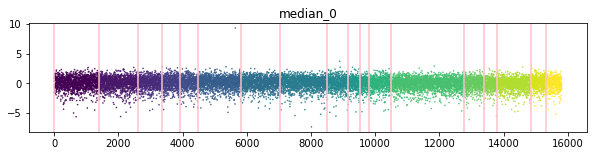

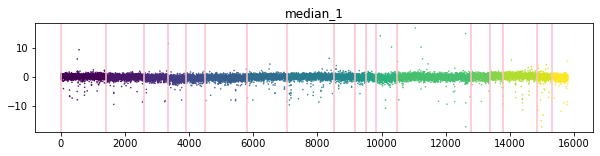

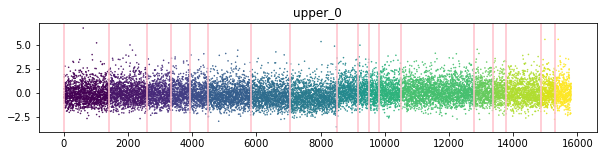

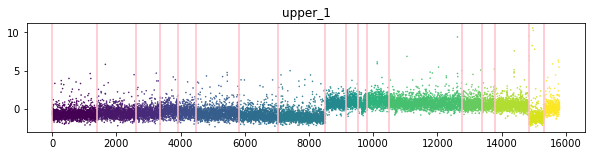

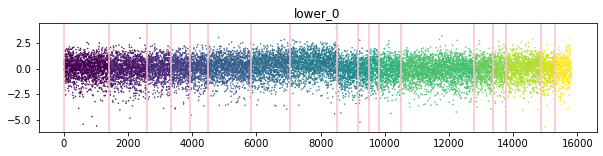

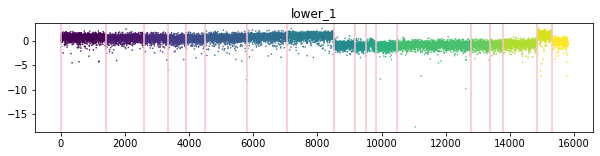

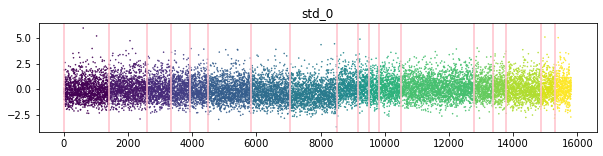

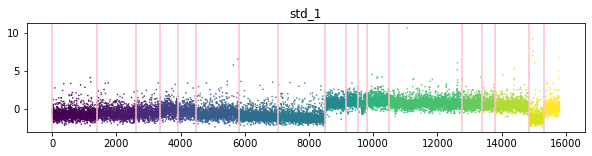

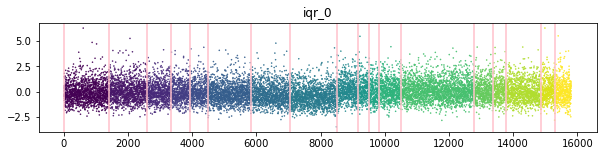

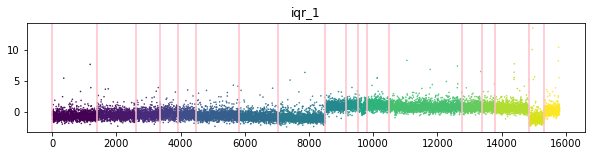

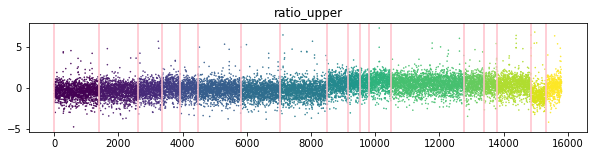

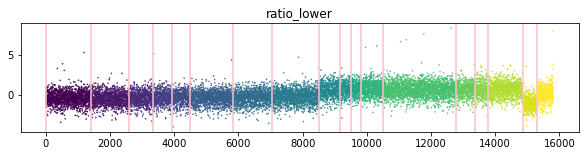

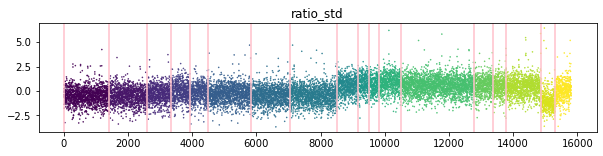

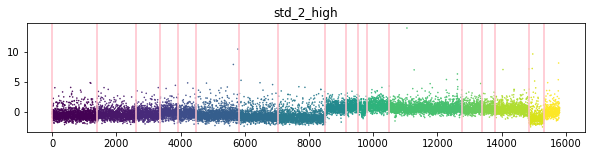

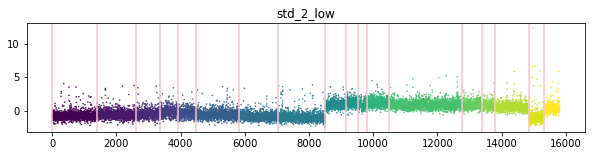

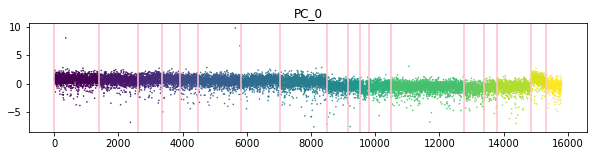

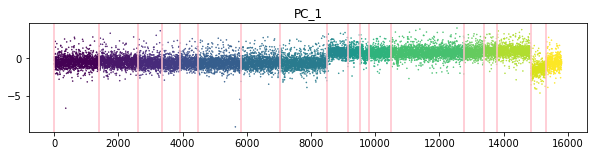

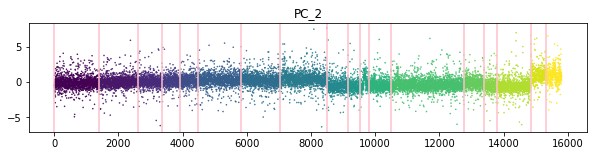

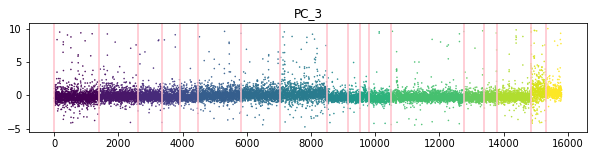

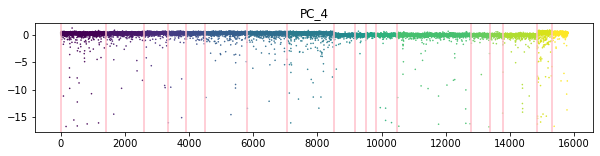

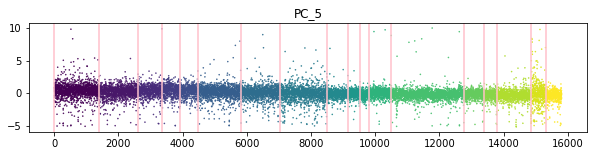

<Figure size 720x288 with 0 Axes>

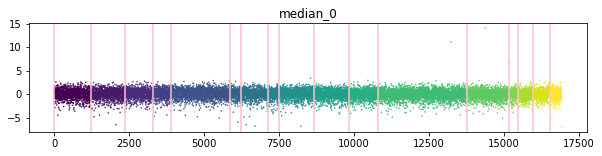

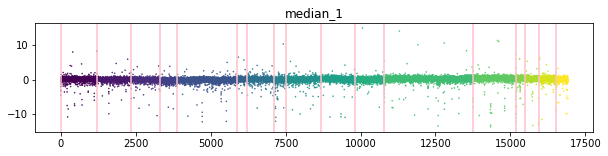

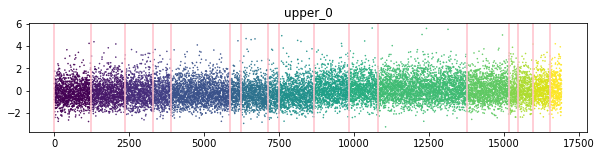

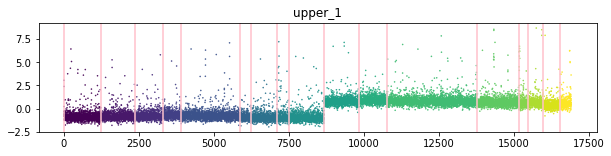

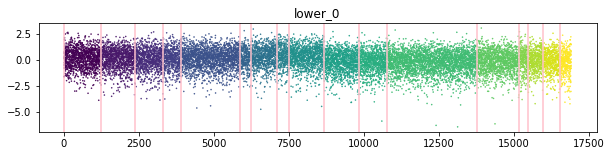

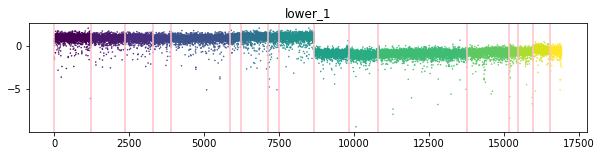

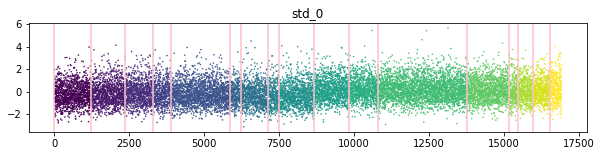

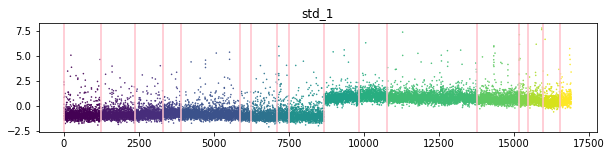

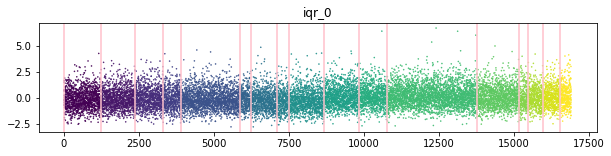

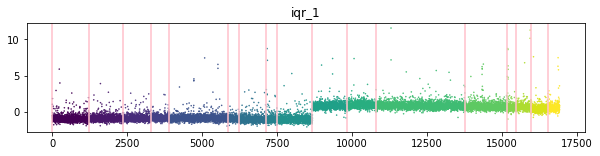

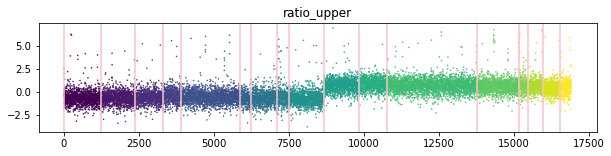

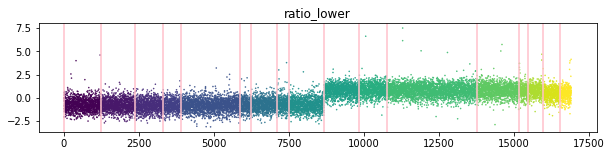

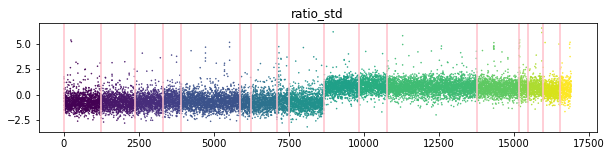

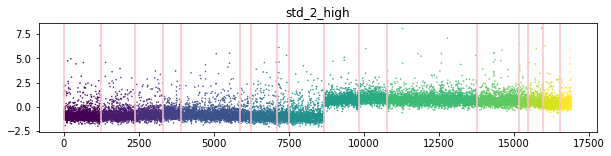

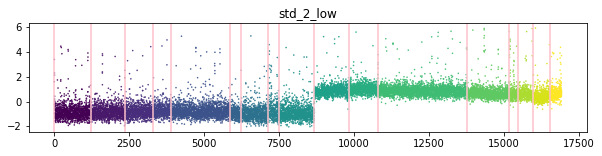

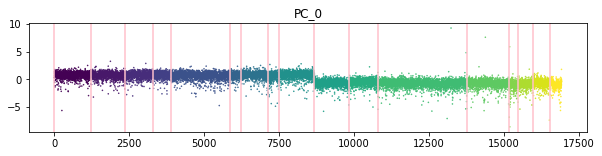

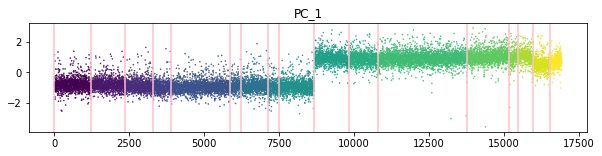

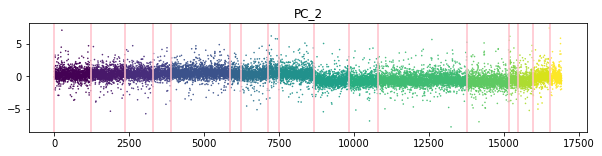

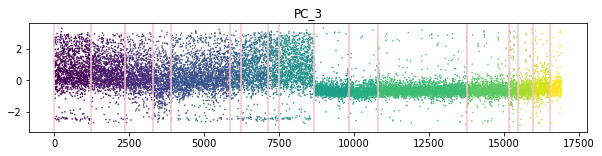

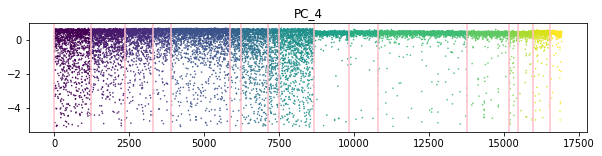

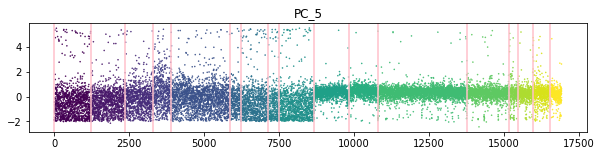

In [136]:
cohort_offset = sys_info.cohort.max() + 1
machines = int_phen["Instrument"].unique().tolist()
int_infos = []
for instrument in machines:
    int_info = pd.merge(int_values, int_phen.loc[int_phen.Instrument == instrument,
                                                      ["SampleNo","DateTime"]],
                        left_index=True,right_on="SampleNo",how="inner")
    
    int_info.sort_values("DateTime",inplace=True)
    X = int_info[features.columns].values
    X -= np.mean(X,axis=0)
    X /= np.std(X,axis=0)
    
    algo_c = rp.KernelCPD(kernel="rbf", min_size=300).fit(
        X
    )
    
    bkps = algo_c.predict(pen=2.)
    bkps = [0] + bkps
    print("%d BKPS" % len(bkps))

    int_info["cohort"] = cohort_offset
    int_info["rank"] = np.arange(int_info.shape[0])
    for b in bkps[1:]:
        int_info.loc[int_info["rank"] >= b,"cohort"] += 1

    plt.figure(figsize=(10,4))
    for i in range(X.shape[1]):
        plt.figure(figsize=(10,2))
        plt.scatter(int_info["rank"],X[:,i],s=.3,c=int_info.cohort)
        for b in bkps[:-1]:
            plt.axvline(int_info["rank"].iloc[b],c="pink")
        plt.title(features.columns[i])
    int_infos.append(int_info)
    cohort_offset = int_info.cohort.max() + 1
int_info = pd.concat(int_infos,axis=0)

34    2978
17    2289
27    1976
12    1471
35    1410
5     1400
10    1328
11    1225
23    1221
6     1200
31    1166
32    1155
24    1136
20    1067
33     953
25     942
29     899
7      742
16     670
13     648
18     605
26     592
8      574
9      571
38     562
22     491
37     490
21     465
19     402
39     390
30     387
28     356
14     356
36     306
15     304
Name: cohort, dtype: int64

In [137]:
int_info.head()

,median_0,median_1,upper_0,upper_1,lower_0,lower_1,std_0,std_1,iqr_0,iqr_1,...,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,SampleNo,DateTime,cohort,rank
0,-3.333294,-0.359899,45.663706,10.845132,-42.523768,-10.349542,34.801211,8.466834,46.861132,10.750426,...,0.710971,0.368297,0.599064,-0.332441,0.926710,-0.175188,INT_116_6580100,2013-03-01 10:19:44,5,0
1,-3.600537,-0.171088,48.400773,10.480065,-43.100410,-10.230594,36.046811,8.453598,48.725918,10.912666,...,0.700790,0.385563,0.600195,-0.335836,0.920601,-0.199268,INT_116_6580000,2013-03-01 10:21:00,5,1
2,-5.924811,-0.391815,46.901510,11.342251,-40.435646,-11.049173,35.346265,8.900048,44.844753,11.420908,...,0.699851,0.385757,0.601166,-0.179452,0.909590,-0.374756,INT_116_4555900,2013-03-01 10:23:33,5,2
3,-4.038082,-0.202431,50.355532,10.674130,-43.063365,-10.637536,36.472622,8.663954,48.067462,11.228411,...,0.699402,0.397970,0.593681,-0.249611,0.914342,-0.318863,INT_116_4555800,2013-03-01 10:24:49,5,3
4,-3.400041,-0.030627,42.412014,10.610659,-39.084948,-10.439574,32.814168,8.557688,42.103940,11.007702,...,0.694409,0.393654,0.602356,-0.323879,0.918492,-0.226881,INT_116_4556000,2013-03-01 10:26:06,5,4


## Age & sex

In [138]:
sys_agesex, int_agesex = get_ages_sex()

Loading INTERVAL phenotypes
(48460, 760)
(45040, 760)
(38832, 760)
(112535, 11)
(102595, 11)
(17768, 772)
(32574, 777)
(32727, 777)
Checked that each Sample has one row max


## Gather

In [139]:
sys_all = pd.merge(sys_agesex,sys_info,left_index=True,right_index=True,how="inner").sort_values("time_col")
sys_all.head()

,SEX,AGE,median_0,median_1,upper_0,upper_1,lower_0,lower_1,std_0,std_1,...,std_2_low,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,time_col,cohort,rank
C0WX14,2,67.0,-4.181785,-0.103070,41.438467,10.609063,-37.487007,-10.764779,32.798989,8.346957,...,7.840189,0.720548,0.307990,0.621251,-0.341616,0.937342,-0.068477,2016-01-12,0,0
C0WX4Z,2,63.0,-3.998882,-0.039965,43.770027,11.106810,-38.494406,-11.197107,33.906347,8.900580,...,8.255723,0.722730,0.343717,0.599600,-0.286391,0.938515,-0.192796,2016-01-12,0,1
C0WX6V,2,64.0,-3.383979,-0.222166,45.864050,11.242917,-43.113459,-11.132685,36.381407,8.918077,...,8.327184,0.721614,0.334550,0.606093,-0.297553,0.940374,-0.164800,2016-01-12,0,2
C0WX7T,2,70.0,-4.076989,0.058005,45.987701,11.104832,-40.152640,-11.469365,34.534457,8.892046,...,7.994955,0.723996,0.332617,0.604314,-0.412580,0.910894,-0.007071,2016-01-12,0,3
C0WX8R,2,71.0,-5.084672,-0.072010,46.665774,10.127888,-42.922255,-10.407640,37.507398,8.307566,...,7.885796,0.725546,0.317799,0.610399,-0.289902,0.945587,-0.147723,2016-01-12,0,4


In [140]:
int_all = pd.merge(int_agesex,int_info,left_index=True,right_on="SampleNo",how="inner").set_index("SampleNo").sort_values("DateTime")
int_all.head()

,SEX,AGE,median_0,median_1,upper_0,upper_1,lower_0,lower_1,std_0,std_1,...,std_2_low,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,DateTime,cohort,rank
SampleNo,,,,,,,,,,,,,,,,,,,,,
INT_116_6580100,1,58.8,-3.333294,-0.359899,45.663706,10.845132,-42.523768,-10.349542,34.801211,8.466834,...,7.263769,0.710971,0.368297,0.599064,-0.332441,0.926710,-0.175188,2013-03-01 10:19:44,5,0
INT_116_6580000,2,22.6,-3.600537,-0.171088,48.400773,10.480065,-43.100410,-10.230594,36.046811,8.453598,...,7.378998,0.700790,0.385563,0.600195,-0.335836,0.920601,-0.199268,2013-03-01 10:21:00,5,1
INT_116_4555900,2,59.4,-5.924811,-0.391815,46.901510,11.342251,-40.435646,-11.049173,35.346265,8.900048,...,7.751925,0.699851,0.385757,0.601166,-0.179452,0.909590,-0.374756,2013-03-01 10:23:33,5,2
INT_116_4555800,2,21.3,-4.038082,-0.202431,50.355532,10.674130,-43.063365,-10.637536,36.472622,8.663954,...,7.957881,0.699402,0.397970,0.593681,-0.249611,0.914342,-0.318863,2013-03-01 10:24:49,5,3
INT_116_4556000,1,49.3,-3.400041,-0.030627,42.412014,10.610659,-39.084948,-10.439574,32.814168,8.557688,...,7.355188,0.694409,0.393654,0.602356,-0.323879,0.918492,-0.226881,2013-03-01 10:26:06,5,4


In [141]:
all_ = pd.concat((sys_all[["SEX","AGE","cohort"]+list(features.columns)],
                  int_all[["SEX","AGE","cohort"]+list(features.columns)]),axis=0)
X = pd.concat([all_[["SEX","AGE"]],pd.get_dummies(all_["cohort"],drop_first=True)],axis=1)
Y = all_[features.columns]
# IT IS DEGENERATE IF WE DON'T DROP THE FIRST LEVEL

In [142]:
lm = LinearRegression(fit_intercept=True)
lm.fit(X,Y)
cohort_coefs = lm.coef_[:,2:]
print(cohort_coefs.shape)

(21, 39)


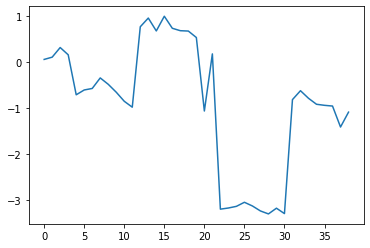

In [143]:
plt.plot(cohort_coefs[9])

In [144]:
for c in all_.cohort.unique().tolist():
    if c == 0: continue
    features.loc[features.index.isin(all_.loc[all_.cohort == c].index.tolist()),features.columns] -= cohort_coefs[:,c-1]

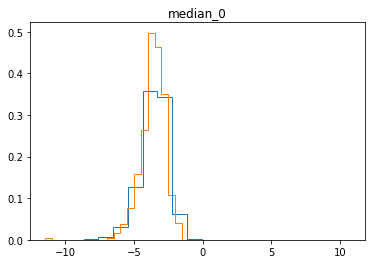

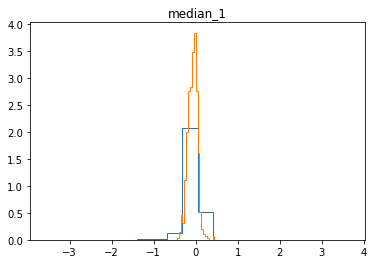

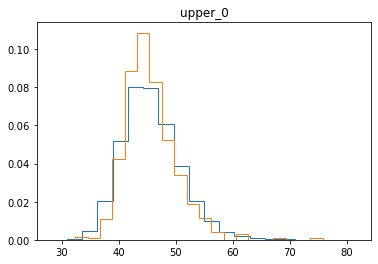

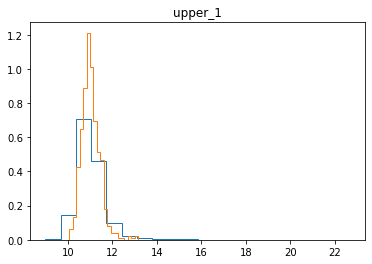

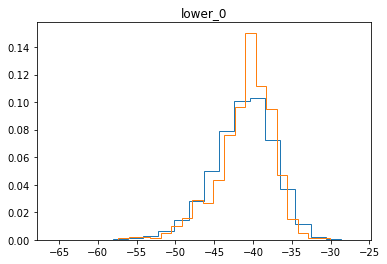

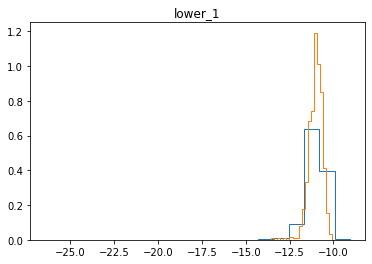

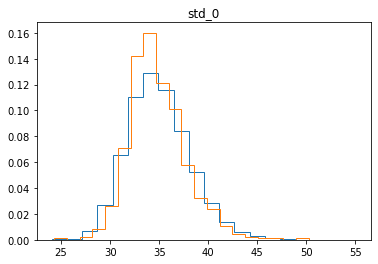

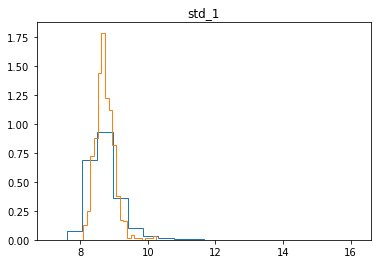

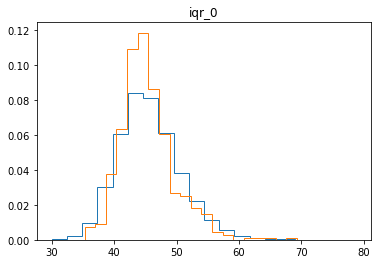

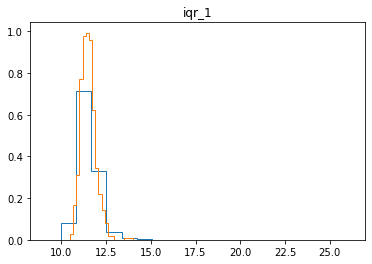

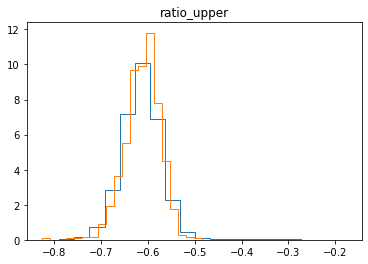

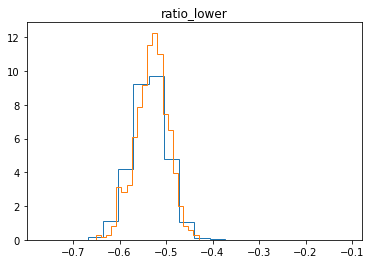

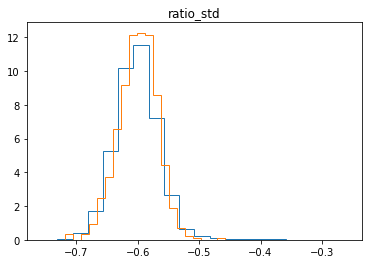

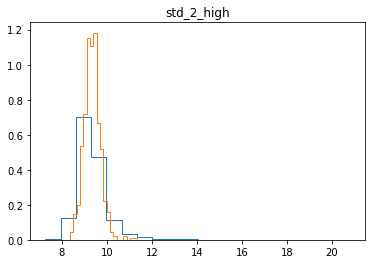

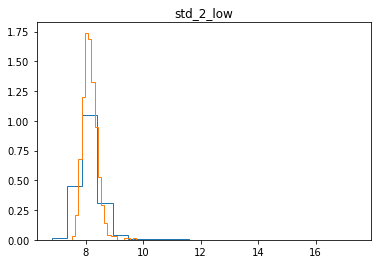

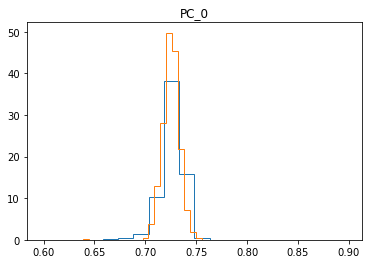

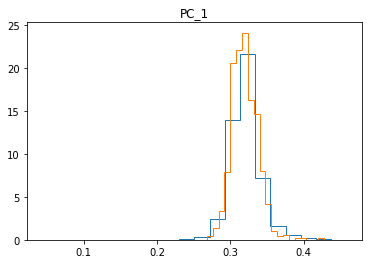

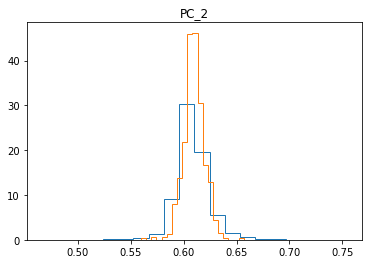

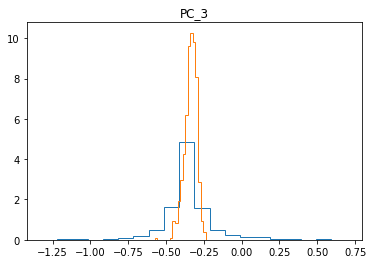

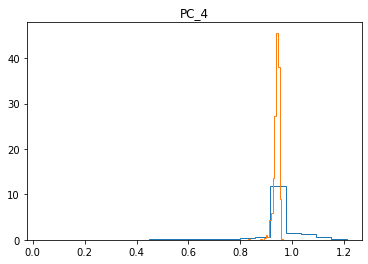

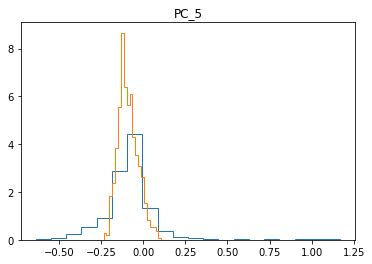

In [145]:
for c in features.columns:
    plt.figure()
    plt.hist(features.loc[features.index.str.contains("INT_116"),c],density=True,bins=20,histtype="step")
    plt.hist(features.loc[~features.index.str.contains("INT_116"),c],density=True,bins=20,histtype="step")
    plt.title(c)

## Clip outliers

In [146]:
for c in features.columns:
    median = np.median(features[c])
    std = np.std(features[c])
    m = median - 4*std
    M = median + 4*std
    outliers = (features[c] - median).abs() > 4*std
    print("%s : %d outliers" % (c, outliers.sum()))
    features[c] = np.clip(features[c],m,M)

median_0 : 92 outliers
median_1 : 304 outliers
upper_0 : 57 outliers
upper_1 : 292 outliers
lower_0 : 45 outliers
lower_1 : 215 outliers
std_0 : 34 outliers
std_1 : 285 outliers
iqr_0 : 64 outliers
iqr_1 : 206 outliers
ratio_upper : 185 outliers
ratio_lower : 60 outliers
ratio_std : 141 outliers
std_2_high : 301 outliers
std_2_low : 307 outliers
PC_0 : 240 outliers
PC_1 : 158 outliers
PC_2 : 263 outliers
PC_3 : 370 outliers
PC_4 : 620 outliers
PC_5 : 290 outliers


# Export

In [147]:
features.to_hdf("%s/processed/features.hdf" % datadir, key="features")